In [40]:
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# dataset import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML
data = pd.read_csv('diabetes_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML


# Exploratory Data Analysis and Preprocessing

In [41]:
# details about the data
print(data)
data.info()
data.describe()

     Pregnancies  Glucose  ...  Age  Outcome
0              6      148  ...   50        1
1              1       85  ...   31        0
2              8      183  ...   32        1
3              1       89  ...   21        0
4              0      137  ...   33        1
..           ...      ...  ...  ...      ...
763           10      101  ...   63        0
764            2      122  ...   27        0
765            5      121  ...   30        0
766            1      126  ...   47        1
767            1       93  ...   23        0

[768 rows x 9 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Zero values in data

In [42]:
print(data['Glucose'].value_counts()[0], data['BloodPressure'].value_counts()[0], data['SkinThickness'].value_counts()[0], data['BMI'].value_counts()[0], data['Insulin'].value_counts()[0])

5 35 227 11 374


In [43]:
# dropping zero value samples and replacing with median where there are many zero values

data = data[(data['BloodPressure']!=0) & (data['BMI']!=0) & (data['Glucose']!=0)]

data['Insulin'].replace(0, data['Insulin'].median(axis=0), inplace=True)
data['SkinThickness'].replace(0, data['SkinThickness'].median(axis=0), inplace=True)
# data['BMI'].replace(0, data['BMI'].median(axis=0), inplace=True)
# data['Glucose'].replace(0, data['Glucose'].median(axis=0), inplace=True)
# data['BloodPressure'].replace(0, data['BloodPressure'].median(axis=0), inplace=True)

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,27.808011,106.505525,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,9.304910,102.669035,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,24.000000,48.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,24.000000,48.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,33.000000,130.500000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


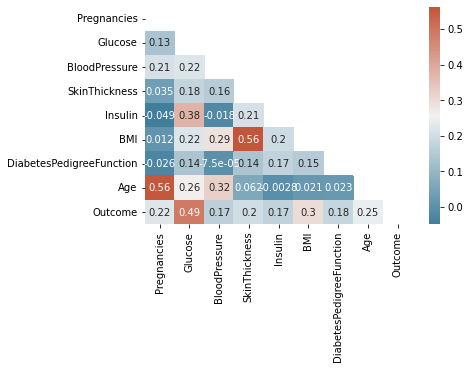

In [44]:
corr = data.corr()
f, ax = plt.subplots()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# there is no high correlation between any features and hence no need to drop any features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa04eed7d10>,
      dtype=object)

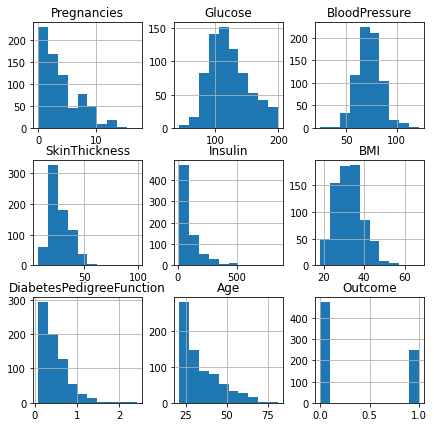

In [45]:
data.hist(figsize=(7, 7))

# Dataset Split

In [46]:
# splitting data into test and train datasets
def split_train_test(input, output, train_ratio=0.8):
    X_train = []
    Y_train = []
    X_test = input.tolist()
    Y_test = output.tolist()
    train_size = math.floor(train_ratio * len(input))
    
    while len(X_train) < train_size:
        index = random.randint(0, len(X_test)-1)
        X_train.append(X_test.pop(index))
        Y_train.append(Y_test.pop(index))
    
    return X_train, X_test, Y_train, Y_test

# standardisation of the input features
# def standardise(data):
#     for i in range(data.shape[1]):
#         data[:][i] = ((data[:][i] - np.mean(data[:][i]))/np.std(data[:][i]))
#     return data

# normalisation of the input features
def normalise(data):
    for i in range(data.shape[1]):
        if i != 0:
            data[:][i] = (data[:][i] - np.min(data[:][i]))/(np.max(data[:][i]) - np.min(data[:][i]))
    return data

# separating input and output features
output = data['Outcome']
input = data.drop('Outcome',axis='columns')

# including bias term in input
newcol = np.ones(np.shape(input)[0])
input.insert(0, "x0", newcol, True)

input = input.to_numpy()
output = output.to_numpy()

# splitting data into train and test datasets
random.seed(0)
X_train, X_test, Y_train, Y_test = split_train_test(input, output, 0.9)
X_train, X_val, Y_train, Y_val = split_train_test(input, output, 0.77)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))
Y_val = np.reshape(Y_val, (Y_val.shape[0], 1))
	
# X_train = standardise(X_train)
# Y_train = standardise(Y_train)
# X_val = standardise(X_val)
# Y_val = standardise(Y_val)

X_train = normalise(X_train)
Y_train = normalise(Y_train)
X_val = normalise(X_val)
Y_val = normalise(Y_val)


# **Batch Gradient Descent**





In [47]:
# to print the confusion matrix and metrics 
def display_matrix(true_pos, true_neg, false_pos, false_neg):
    matrix = [['  ', 'PP', 'PN'], ['AP', true_pos, false_neg], ['AN', false_pos, true_neg]]
    for i in matrix:
        for j in i:
            print(j, end = '   ')
        print()
    print('PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative')
    accuracy = (1/(true_pos + true_neg + false_pos + false_neg))*(true_pos + true_neg)*100
    print('\nAccuracy:')
    print(accuracy)
    precision = (1/(true_pos + false_pos))*true_pos
    print('\nPrecision:')
    print(precision)
    recall = (1/(true_pos + false_neg))*true_pos
    print('\nRecall:')
    print(recall)
    f1score = (2/(precision + recall))*(precision*recall)
    print('\nF1 score:')
    print(f1score)

# calculating the tp, tf, tn, fn for confusion matrix
def confusion_matrix(y_pred, output):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    ctr = 0
    for i in y_pred:
        if i == 1 and output[ctr] == 1:
            true_pos += 1
        elif i == 0 and output[ctr] == 0:
            true_neg += 1
        elif i == 1 and output[ctr] == 0:
            false_pos += 1
        elif i == 0 and output[ctr] == 1:
            false_neg += 1
        ctr += 1

    display_matrix(true_pos, true_neg, false_pos, false_neg)

# calculation of hypothesis 
def hypothesis(theta, x):
    z = np.dot(x, theta)
    return 1.0 / (1.0 + np.exp(-z))

# batch gradient descent for logistic regression
def batch_gradient_descent(input, output, learning_rate, itr):

    h_theta_vec = []
    theta_vec = []
    cost_vec = []
    
    num_train_samples = np.shape(input)[0]
    num_features = np.shape(input)[1]

    # initialise model parameters and cost to one
    theta_curr = np.ones((num_features, 1))
    cost = 0

    y = output
    y = np.reshape(y, (y.shape[0], 1))
    x = input
    
    for i in range(itr):

        # predicted values
        h_theta = hypothesis(theta_curr, x)

        # loss 
        loss = h_theta - y

        # cost
        cost = (-1/num_train_samples) * np.sum(y * np.log(h_theta + 1e-15) + (1 - y) * np.log(1 - h_theta + 1e-15))
        
        # gradients
        d_cost = (2/num_train_samples) * np.dot(x.T, loss)
        
        # step size
        step = learning_rate*d_cost

        # update the parameters
        theta_curr = theta_curr - step
        
        h = np.sum(h_theta, axis = 0)
        h_theta_vec.append(h)
        theta_vec.append(theta_curr)
        cost_vec.append(cost)

    return cost_vec, theta_vec, h_theta_vec, theta_curr

def predict_val(input, theta):
    y = np.dot(input, theta)
    y_pred = []
    for i in y:
        if i > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred



     PP   PN   
AP   79   108   
AN   54   316   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
70.91561938958708

Precision:
0.593984962406015

Recall:
0.4224598930481283

F1 score:
0.49375


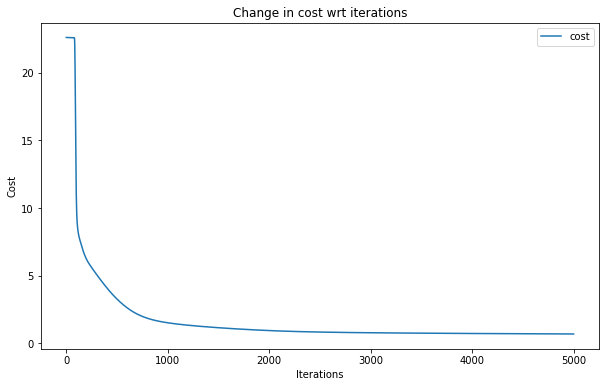

In [104]:
itr = 5000
learning_rate = 0.0001
cost_vec, theta_vec, h_theta_vec, theta = batch_gradient_descent(X_train, Y_train, learning_rate, itr)
y_pred = predict_val(X_train, theta)
print()
confusion_matrix(y_pred, Y_train)

plt.figure(figsize=(10,6))
plt.plot(cost_vec,label='cost')
plt.title('Change in cost wrt iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

     PP   PN   
AP   25   37   
AN   18   87   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
67.06586826347306

Precision:
0.5813953488372093

Recall:
0.4032258064516129

F1 score:
0.4761904761904762


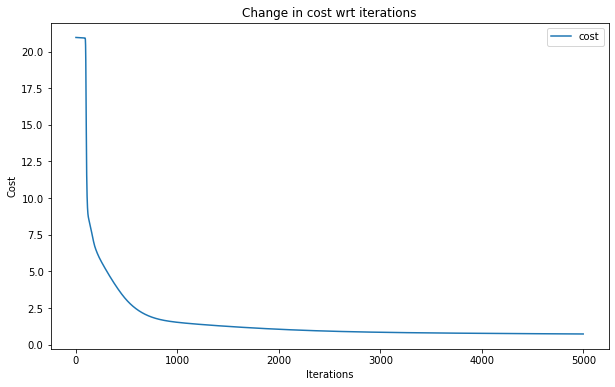

In [105]:
cost_vec, theta_vec, h_theta_vec, theta = batch_gradient_descent(X_val, Y_val, learning_rate, itr)
y_pred = predict_val(X_val, theta)
confusion_matrix(y_pred, Y_val)

plt.figure(figsize=(10,6))
plt.plot(cost_vec,label='cost')
plt.title('Change in cost wrt iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [106]:
y_pred = predict_val(X_test, theta)
confusion_matrix(y_pred, Y_test)

     PP   PN   
AP   10   18   
AN   7   38   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
65.75342465753424

Precision:
0.5882352941176471

Recall:
0.3571428571428571

F1 score:
0.44444444444444436


# Using sklearn

In [94]:
print('Using sklearn LogisticRegression:\n')
log_reg = linear_model.LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, Y_train.reshape(X_train.shape[0], ))
accuracy = log_reg.score(X_test, Y_test)
print(accuracy*100)

y_pred = log_reg.predict(X_test)
confusion_matrix(y_pred, Y_test)
print()

print('\nUsing sklearn SGDClassifier:\n')
sgd_log_reg = linear_model.SGDClassifier(max_iter=1000, learning_rate = 'optimal', verbose = 1)
sgd_log_reg.fit(X_train, Y_train.reshape(X_train.shape[0], ))
accuracy = log_reg.score(X_test, Y_test)
print(accuracy*100)
y_pred = log_reg.predict(X_test)
confusion_matrix(y_pred, Y_test)

Using sklearn LogisticRegression:

73.97260273972603
     PP   PN   
AP   12   16   
AN   3   42   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
73.97260273972603

Precision:
0.8

Recall:
0.42857142857142855

F1 score:
0.5581395348837209


Using sklearn SGDClassifier:

-- Epoch 1
Norm: 6006.52, NNZs: 9, Bias: -153.763025, T: 557, Avg. loss: 77571.286129
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 4734.49, NNZs: 9, Bias: -236.465415, T: 1114, Avg. loss: 61424.105854
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 4369.67, NNZs: 9, Bias: -291.357013, T: 1671, Avg. loss: 46158.670294
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 3566.55, NNZs: 9, Bias: -329.082313, T: 2228, Avg. loss: 35488.446643
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 3498.59, NNZs: 9, Bias: -374.789782, T: 2785, Avg. loss: 29396.716544
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 3149.21, NNZs: 9, Bias: -401.679686, T: 3342, Avg

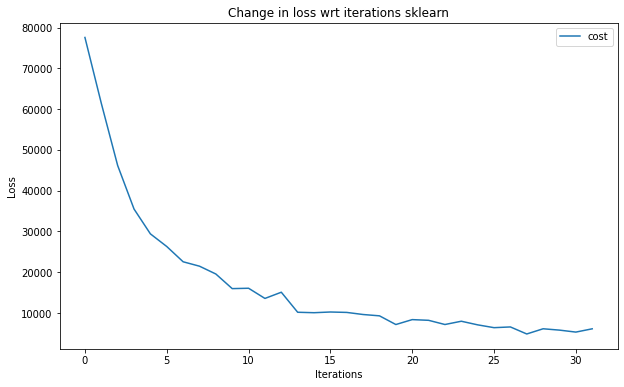

In [109]:
# Loss plot for SGDClassifier. Data obtained from run on which convergence was achieved in 33 epochs.
loss_vec = [77571.286129, 61424.105854, 46158.670294, 35488.446643, 29396.716544, 26294.993074, 22551.942857, 21469.719487, 19551.222754, 15968.059318, 16057.837465, 13559.794649, 15081.937304, 10168.792924, 10058.814571, 10230.870481, 10129.307032, 9615.909219, 9291.123911, 7158.903822, 8363.726587, 8193.056471, 7163.387581, 7966.964149, 7080.219390, 6387.949238, 6566.594688, 4841.893529, 6116.388455, 5787.039624, 5303.614621, 6109.068211]
plt.figure(figsize=(10,6))
plt.plot(loss_vec,label='cost')
plt.title('Change in loss wrt iterations sklearn')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Stochastic Gradient Descent**

In [107]:

def display_matrix(true_pos, true_neg, false_pos, false_neg):
    matrix = [['  ', 'PP', 'PN'], ['AP', true_pos, false_neg], ['AN', false_pos, true_neg]]
    for i in matrix:
        for j in i:
            print(j, end = '   ')
        print()
    print('PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative')
    accuracy = (1/(true_pos + true_neg + false_pos + false_neg))*(true_pos + true_neg)*100
    print('\nAccuracy:')
    print(accuracy)
    precision = (1/(true_pos + false_pos))*true_pos
    print('\nPrecision:')
    print(precision)
    recall = (1/(true_pos + false_neg))*true_pos
    print('\nRecall:')
    print(recall)
    f1score = (2/(precision + recall))*(precision*recall)
    print('\nF1 score:')
    print(f1score)

def confusion_matrix(y_pred, output):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    ctr = 0
    for i in y_pred:
        if i == 1 and output[ctr] == 1:
            true_pos += 1
        elif i == 0 and output[ctr] == 0:
            true_neg += 1
        elif i == 1 and output[ctr] == 0:
            false_pos += 1
        elif i == 0 and output[ctr] == 1:
            false_neg += 1
        ctr += 1

    display_matrix(true_pos, true_neg, false_pos, false_neg)


# stochastic gradient descent for logistic regression

def hypothesis(theta, x):
    z = np.dot(x, theta) 
    return 1 / (1 + np.exp(-z))

def stochastic_gradient_descent(input, output, learning_rate, itr):

    h_theta_vec = []
    theta_vec = []
    cost_vec = []
    
    num_train_samples = np.shape(input)[0]
    num_features = np.shape(input)[1]

    # initialise model parameters and cost to zero
    theta_curr = np.ones((num_features, 1))
    cost = 0

    y = np.array(output)
    y = np.reshape(y, (y.shape[0], 1))
    x = np.array(input)
    len = x.shape[0]
    
    for i in range(itr):
        index = np.random.permutation(len)
        cost = 0
        for j in index:

            xi = x[j][:].T
            yi = y[j]

            # xi = np.reshape(xi, (xi.shape[0], 1))
            yi = np.reshape(yi, (yi.shape[0], 1))

            # predicted values
            h_theta = hypothesis(theta_curr, xi)
            h_theta_vec.append(h_theta)

            # loss 
            loss = h_theta - yi

            # cost
            cost = (-1) * np.sum(yi * np.log(h_theta + 1e-15) + (1 - yi) * np.log(1 - h_theta  + 1e-15))
            cost_vec.append(cost)
            
            # gradients
            d_cost = xi * loss
            
            # step size
            step = learning_rate*d_cost
            
            # update the parameters
            theta_curr = theta_curr - step.T
            theta_vec.append(theta_curr)

    return cost_vec, theta_vec, h_theta_vec, theta_curr

def predict_val(input, theta):
    y = np.sum(np.dot(input, theta), axis = 1)
    y_pred = []
    for i in y:
        if i > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred


     PP   PN   
AP   3   184   
AN   2   368   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
66.6068222621185

Precision:
0.6000000000000001

Recall:
0.0160427807486631

F1 score:
0.03125


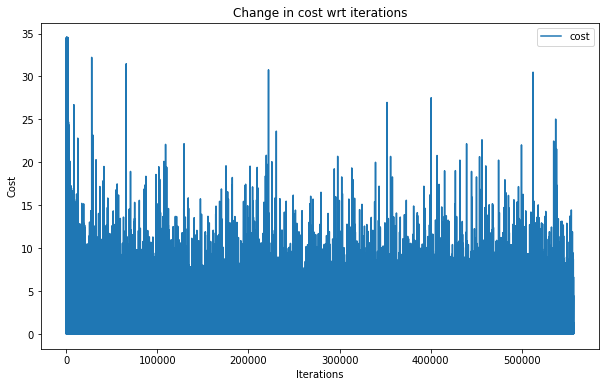

In [111]:
itr = 1000
learning_rate = 0.00005
cost_vec, theta_vec, h_theta_vec, theta = stochastic_gradient_descent(X_train, Y_train, learning_rate, itr)
y_pred = predict_val(X_train, theta)

confusion_matrix(y_pred, Y_train)

plt.figure(figsize=(10,6))
plt.plot(cost_vec,label='cost')
plt.title('Change in cost wrt iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

     PP   PN   
AP   31   31   
AN   24   81   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
67.06586826347306

Precision:
0.5636363636363636

Recall:
0.5

F1 score:
0.5299145299145299


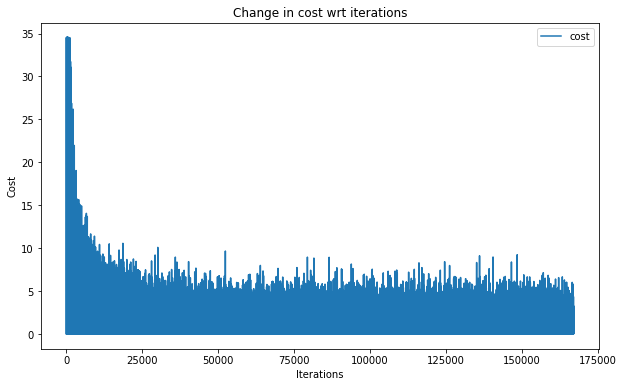

In [113]:
cost_vec, theta_vec, h_theta_vec, theta = stochastic_gradient_descent(X_val, Y_val, learning_rate, itr)
y_pred = predict_val(X_val, theta)
confusion_matrix(y_pred, Y_val)

plt.figure(figsize=(10,6))
plt.plot(cost_vec,label='cost')
plt.title('Change in cost wrt iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [70]:
y_pred = predict_val(X_test, theta)
confusion_matrix(y_pred, Y_test)

(73, 9) (9, 9)
     PP   PN   
AP   28   0   
AN   45   0   
PP: Predicted Positive, PN: Predicted Negative, AP: Actual Positive, AP: Actual Negative

Accuracy:
38.35616438356164

Precision:
0.3835616438356164

Recall:
1.0

F1 score:
0.5544554455445544
